**Recurrent Neural Networks**

When you are dealing with time-series or spatial/neighbor dependencies, Recurrent Neural Networks is a good choice. RNNs are used in predicting the future, natural language processing, sentiment analysis, autonomous cars, etc. RNNs are very good predicting the next step (next note in a melody, next word in a sentence, next price of a stock, where the car should drive next).

RNN deal with data that can have arbitrary length, such a document, historic prices, etc. Two main difficulties of RNN that we will explore are the unstable gradients and limited short-term memory. 

Regular NN can be also applied to the series data and very powereful models can be constructed by combination of CNN and RNN. 

# Recurrent Neurons

Up to now we have mostly looked at feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer. 

A recurrent neural network adds connections pointing backward. Singe neuron RNN: 

![Neuron inner working](images/image_14_1.png)

At each time step $t$ (frame) recurrent neuron receives the inputs $x(t)$ as well as its own output from the previous time step, $y_{(t–1)}$. The image shows the network unrolling through time.

Below is the RNN with multiple neurons. 

![Neuron inner working](images/image_14_2.png)

Each recurrent neuron weight $W_x$ for inputs x(t) and the weight $W_y$ for the outputs of the previous time step, $y_{(t–1)}$.  Below is the output of a single neuron (b is the bias term and $\phi(\cdot)$ is the activation function, e.g., ReLU1):
$$y_{(t)} = \phi(x_{(t)}^T \cdot W_x + y_{(t-1)}^T \cdot W_y + b)$$
For the whole layer of neurons we can use vectorized form:
$$Y_{(t)} = \phi(X_{(t)} \cdot W_x + Y_{(t-1)} \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b)$$
with $W = [W_x , W_y]$

* $Y_{(t)}$ is a $m \times n_{neurons}$ matrix with layer’s outputs at step $t$ for each instance in the mini-batch.$m$ is the number of instances in the mini-batch, and $n_{neurons}$ is the number of neurons.
* $X_{(t)}$ is an $m \times n_{inputs}$ matrix containing the inputs for all instances ($n_{inputs}$ is the number of input features).
* $W_x$ is an $n_{inputs} \times n_{neurons}$ matrix with connection weights for the inputs of the current time step.
* $W_y$ is an $n_{neurons} \times n_{neurons}$ matrix with connection weights for the outputs of the previous time step.
* $W$ is the concatenated matrix of $W_x$ and $W_y$ with the shape $(n_{inputs} + n_{neurons}) \times n_{neurons}$. 
* $b$ is a vector size $n_{neurons}$ with each neuron’s bias term.

$Y_{(t)}$ is a function of $X_{((t)}$ and $Y_{((t–1)}$, which is a function of $X_{((t–1)}$ and $Y_{((t–2)}$,  and so on.

This makes $Y_{((t)}$ a function of all the inputs since time $t = 0$ (that is, $X_{((0)}$, $X_{((1)}$, …, $X_{((t))}$. 

At the first time step, $t = 0$, there are no previous outputs, so they are typically assumed to be all zeros.

# Memory cells

The output of a recurrent neuron at time step $t$ forms a memory from a function of all the inputs from previous time steps.
Network preserves some, **but not all**, infromation from previous steps (memory cells).
$$h_{(t)} = f(h_{(t-1)}, x_{(t)})$$

italicized text![Neuron inner working](images/image_14_3.png)

# Input and Output Sequences

* An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs (top left). This is useful in predicting times series. 

* RNN can be fed a sequence of inputs, and ignore all outputs except for the last one (top-right). This is useful when updating a score, for example a sentiment score (from –1 [hate] to +1 [love]).

* RNN can work with  a single input at the first time step and zeros for all other time steps (bottom-left). This is a vector-to-sequence network. Input could be an image, and the output could be a caption for that image.

* Sequence-to-vector network (encoder), followed by a vector-to-sequence network, called a decoder (bottom-right).  For example, this can be used for translating a sentence from one language to another. We would translate words in another language, You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language.

This two-step model, called an Encoder–Decoder, works much better than trying to translate on the fly with a single sequence-to-sequence RNN, since the last words of a sentence can affect the first words of the translation, so you need to wait until you have heard the whole sentence before translating it.


![Neuron inner working](images/image_14_4.png)

#Training RNNs

RNNs are unrolled over time and then coefficients are estimated through back-propagation through time. 

1. forward pass through the unrolled network. Then the output sequence is evaluated using a cost function $C(Y_{(0)},Y_{(1)},...,Y_{(T)})$. A cost function may ignore some outputs, as shown in the next figure where all outputs are ignored except for the very last one. 

2. the gradients of the cost function are then propagated backward through the unrolled network . 

3. the model parameters are updated
using the gradients computed during BPTT for all outputs used in the cost function (last 3 steps in the figure). As BPTT is used at each step, all coefficients are updated. 


# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [163]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


Then of course we will need TensorFlow:

In [164]:
import tensorflow as tf

# Forecasting Time Series

Time series can be univariate  (stock price), or multi-variate (multiple stocks). Two most common tasks are predictiong and imputation (filling the missing parts). Next we try simple forecasting of univariate articfical time-series.



### Generate the Dataset

In [165]:
# Generate a random sime series. Batch_size is the number of series generated. Each series has the lenghth of n_steps. One value per step -- 
#series are univariate. The function returns a NumPy array of shape [batch
#size, time steps, 1], where each series is the sum of two sine waves of fixed amplitudes
#but random frequencies and phases, plus a bit of noise
def generate_time_series(batch_size, n_steps):
    # Generarate series of random numbers [4x10000x1]. 
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    # Divide space between 0 and 1 by the number of steps
    time = np.linspace(0, 1, n_steps)
    # start wave 1
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

#When dealing with time series (and other types of sequences such
#as sentences), the input features are generally represented as 3D
#arrays of shape [batch size, time steps, dimensionality], where
#dimensionality is 1 for univariate time series and more for multivariate
#time series.    

In [166]:
np.random.seed(42)
# 50 steps in each time-series
n_steps = 50
# generate 10000 series for training. Generate extra step for prediction
series = generate_time_series(10000, n_steps + 1)
# 7000 series for training, 2000 - validation, 1000 testing. 
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [167]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


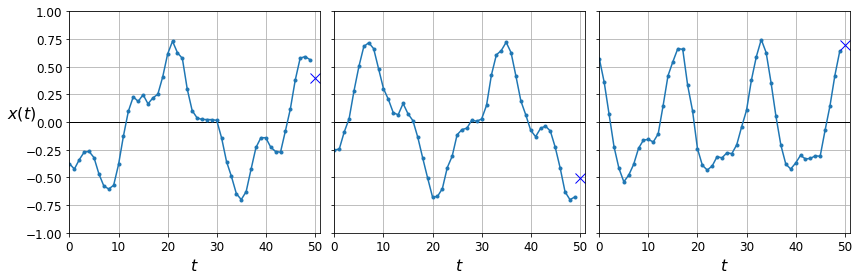

In [168]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

The goal is to predict the last step.

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [169]:
# We will assume that the output equal to step 50, the last step we observe.
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

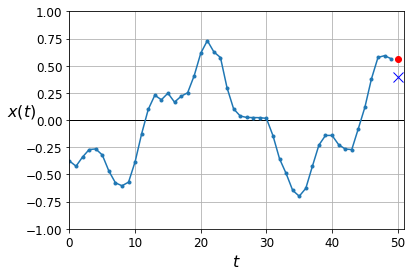

In [170]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()
# Not bad :) 

Linear predictions:

In [171]:
# Neural network with no hidden layers is equivalent to linear regression. Though the coeffients are learnt rather than estimated from matrix multiplication.
# This is not RNN network
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 767us/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 487us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 583us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 538us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 613us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 573us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 604us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 635us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 605us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 557us/step - loss: 0.006

In [172]:
model.evaluate(X_valid, y_valid)
# 5 times better than a naive approach

63/63 [==============================] - 0s 355us/step - loss: 0.0042


0.004168087150901556

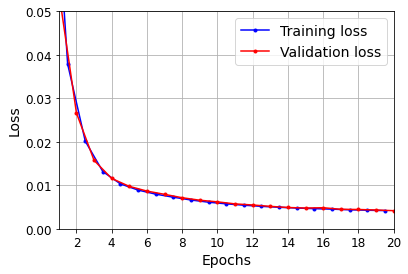

In [173]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

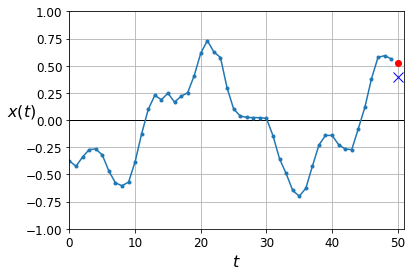

In [174]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

We build a simple RNN with a single layer, with a single
neuron. The model will read the length of the sequence and change None parameter to it. 

By default, the SimpleRNN layer uses the hyperbolic tangent activation function.
It works exactly as we saw earlier: the initial state $h_{(init)}$ is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, $x_{(0)}$.


The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result producing the first output $y_{0}$. In
In a simple RNN, this output is also the new state $h_{(0)}$.

This new state is passed to the same recurrent neuron
along with the next input value, $x_{(1)}$, and the process is repeated until the last time step. 

In [175]:
np.random.seed(42)
tf.random.set_seed(42)
# Single-neuron RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0116 - val_loss: 0.0110

In [176]:
model.evaluate(X_valid, y_valid)
# OK, but worse than the linear model.
# In the linear regression model there is one parameters + bias per step -- 51 parameters
# In each neuron there is just on parameter per input, per hidden dimensions and bias, this has
#just 3 parameters per neuron.

# RNNs can learn seasonality, so you don't have to remove it. 

63/63 [==============================] - 0s 1ms/step - loss: 0.0109


0.010881561785936356

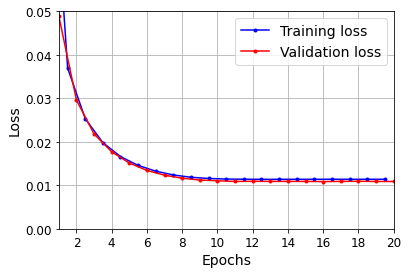

In [177]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

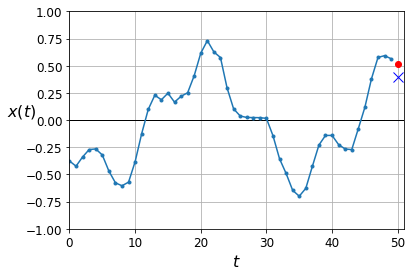

In [178]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

![Neuron inner working](images/Figure_15_7.png)
Instead of recurring neurons we will have a layer or the whole network of recurrent layers.

In [179]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
# convert input shape into a layer of 20 neurons
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
# return_sequences=True returns output data for all steps, not just the predictions.
    keras.layers.SimpleRNN(20, return_sequences=True),
    # Another layer of 20 neurons
    keras.layers.SimpleRNN(1)
    # This layer is not ideal because hidden layers are collapsed into one number going into RNN neuron. 
    #Furthermore the tanh actication function maybe not be optimal for value prediction tasks. 
    #So in the next model we will use Dense layer which will aggregate information from all 20 neurons in the
    #hidden layer and by default has a faster ReLU activation function. 
])

model.compile(loss="mse", optimizer="adam")  
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0035 - val_lo

In [180]:
model.evaluate(X_valid, y_valid)
# previous best OLS MSE = 0.004168087150901556. So it's 30% better than OLS

63/63 [==============================] - 0s 4ms/step - loss: 0.0029


0.002910564187914133

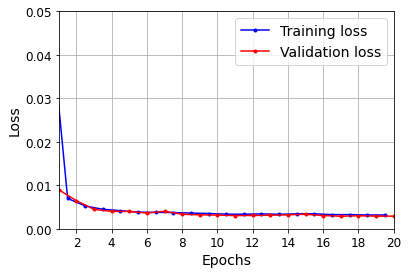

In [181]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

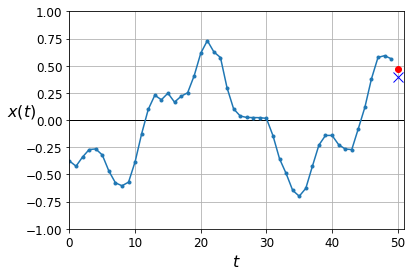

In [182]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [183]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0030 - val_lo

In [184]:
model.evaluate(X_valid, y_valid)
# Using Dense output layer slightly improved the result and it also faster. 

63/63 [==============================] - 0s 3ms/step - loss: 0.0026


0.002623623702675104

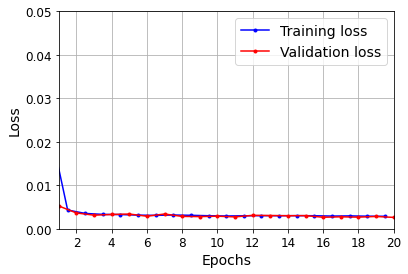

In [185]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

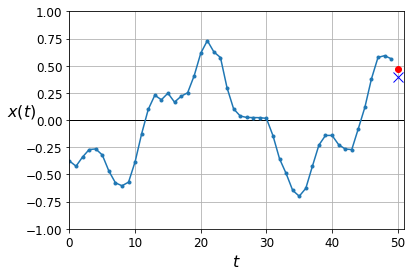

In [186]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

Before we predicted one step ahead, which is less useful than forecasting using several periods into the future. The additional benefit is that the loss function includes the the losses from 10 steps, not just a loss from one -- which is more robust and speed up the training. 


In [187]:
np.random.seed(43) # not 42, as it would give the first series in the train set
# add 10 more steps to the series 
series = generate_time_series(1, n_steps + 10)
# Y is the future 10 steps, X is past 50 steps
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
# try prediction of further steps using the last model we estimates (single step prediction)
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    # append prediction to the X data to generate new prediction
    X = np.concatenate([X, y_pred_one], axis=1)
# get all 10 prediction steps
Y_pred = X[:, n_steps:]

In [188]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


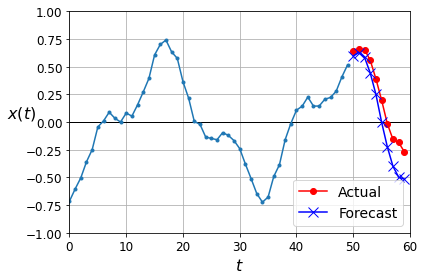

In [189]:
# Make a graph of series prediction. Just a show of the problem
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

 We first need to regenerate the sequences with 9 more time steps.

In [190]:
np.random.seed(42)
n_steps = 50
# Full series has 10 more steps
series = generate_time_series(10000, n_steps + 10)
# X has 10 less steps. The rest of the breakdows is the same as above
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [191]:
# Use the model estimated in the one-step ahead problem
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [192]:
# Validation data 2000 series with 10 steps.
Y_pred.shape

(2000, 10)

In [193]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510857

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [194]:
# last step prediction
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

Next we will try to predict 10 steps ahead in the same time, not one-by-one

In [195]:
# Construct using linear regression model predicting 10 steps ahead
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    # out put has 10 steps
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 759us/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 532us/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 552us/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 525us/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 521us/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 532us/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 539us/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 531us/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 531us/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 542us/step - loss: 0.022

Now let's create an RNN that predicts all 10 next values at once. The model is not predictive, it has access to the whole sequency.

In [196]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    # Use Dense layers 
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0110 - val_lo

In [197]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

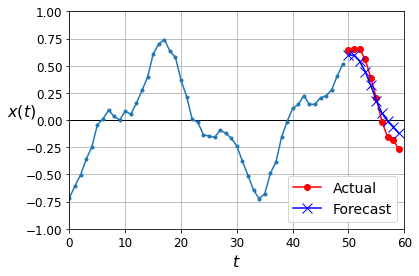

In [198]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [199]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
# One Y has 10 steps are for each step in X
Y = np.empty((10000, n_steps, 10)) 
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [200]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [201]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    # We predict 10 steps that are in sequence
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
# Let us add a metric of last step MSE
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0366 - val_last_time_step_mse: 0.0264
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0323 - last_time_step_mse: 0.0212 - val_loss: 0.0343 - val_last_time_step_mse: 0.0244
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0297 - last_time_step_mse: 0.0186 - val_loss: 0.0284 - val_last_time_step_mse: 0.0164
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0274 - last_time_step_mse: 0.0153 - val_loss: 0.0282 - val_last_time_step_mse: 0.0196
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0251 - last_time_step_mse: 0.0126 - val_loss: 0.0215 - val_last_time_step_mse: 0.0081
Epoch 7/20
219/219 [==

In [202]:
np.random.seed(43)
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

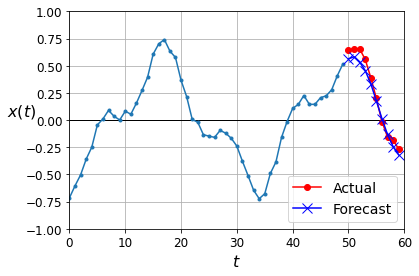

In [203]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

RNN has the same tricks as DNN: parameter initialization, optimizer, drop-out, etc. Though non-saturating functions (it can go to infitinity), such as ReLU does not help because same weights applied in many steps and if they slightly increase between them it can lead to the gradient explosion. Hyperbolic tangent function is bounded between -1 and 1 and used as a default fro RNN.

Batch normalization does not produce good results because it has to be used for each layer of each step and it is hard and inefficient.  

There is additional tool: layers normalization instead of normilizes across batches it normilizes across features. 


## Training a sequence classifier

# Deep RNN with Batch Norm

In [204]:
np.random.seed(42)
tf.random.set_seed(42)



model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [==

# Deep RNNs with Layer Norm

In [210]:
from tensorflow.keras.layers import LayerNormalization

In [206]:
# We embed several function here:
# The object we will transform is the keras layer
# Example of the user-defined function
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        # We load number of input and output connections for a layer
        # Normilize before activation function is applied, so it None
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        # Normilize layers
        self.layer_norm = LayerNormalization()
        # Apply activation function
        self.activation = keras.activations.get(activation)
        # Get initial state of the next layer
    def call(self, inputs, states):
        # return outputs for outouts y and hidden states h
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [211]:
np.random.seed(42)
tf.random.set_seed(42)

from tensorflow_addons.rnn.layer_norm_simple_rnn_cell import LayerNormSimpleRNNCell as RNN_norm

model = keras.models.Sequential([
    keras.layers.RNN(RNN_norm(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(RNN_norm(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 32ms/step - loss: 0.1696 - last_time_step_mse: 0.1641 - val_loss: 0.0745 - val_last_time_step_mse: 0.0698
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0635 - last_time_step_mse: 0.0570 - val_loss: 0.0566 - val_last_time_step_mse: 0.0504
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0535 - last_time_step_mse: 0.0464 - val_loss: 0.0502 - val_last_time_step_mse: 0.0432
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0469 - last_time_step_mse: 0.0386 - val_loss: 0.0436 - val_last_time_step_mse: 0.0341
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0411 - last_time_step_mse: 0.0306 - val_loss: 0.0384 - val_last_time_step_mse: 0.0277
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0376 - last_time_step_mse: 0.0261 - val_loss: 0.0359 - val_last_time_step_mse: 0.0248
Epoch 7/20
219/219 [==

In [212]:
np.random.seed(42)
tf.random.set_seed(42)
# packaged function from tensor flow addons
from tensorflow_addons.rnn.layer_norm_simple_rnn_cell import LayerNormSimpleRNNCell as RNN_norm

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))# it did not improve our results, the exploding gradient is an unlikely problem in our series.

Epoch 1/20
219/219 [==============================] - 7s 30ms/step - loss: 0.1591 - last_time_step_mse: 0.1499 - val_loss: 0.0734 - val_last_time_step_mse: 0.0624
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0638 - last_time_step_mse: 0.0505 - val_loss: 0.0566 - val_last_time_step_mse: 0.0423
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0531 - last_time_step_mse: 0.0375 - val_loss: 0.0509 - val_last_time_step_mse: 0.0342
Epoch 4/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0471 - last_time_step_mse: 0.0311 - val_loss: 0.0442 - val_last_time_step_mse: 0.0286
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0428 - last_time_step_mse: 0.0273 - val_loss: 0.0418 - val_last_time_step_mse: 0.0258
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0395 - last_time_step_mse: 0.0243 - val_loss: 0.0382 - val_last_time_step_mse: 0.0229
Epoch 7/20
219/219 [==

# LSTMs

As data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. If you are translating a setence and when you reached the end, you forgot the begining, the translation is very difficult. The answer is Long Short-term Memory cell (LSTM). It is optimized when running on GPU. 

![Neuron inner working](images/LTSM.png)


the LSTM cell looks like regular cell, but it splits in two vectors: $h_{(t)}$ and $c_{(t)}$ (“c” stands for “cell”). You can think of $h_{(t)}$ as the short-term state and $c_{(t)}$ as the long-term state.

* The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it.
* long-term state $c_{(t–1)}$ goes through forget gate dropping some memories and the add memories. 
* Then part of long-term memory is added to short term via output gate and all of it sent along to next cell.
* the current input vector $x_{(t)}$ and the previous short-term state $h_{(t–1)}$ are fed to four different fully connected layers: 
1. The main layer that outputs $g_{(t)}$. It analyzes the current inputs $x_{(t)}$ and the previous (short-term) state $h_{(t–1)}$. In has $tanh$ activation function.
2. The layers $f_{(t)}$,$i_{(t)}$ and $o_{(t)}$ are gate-controllers with logistic activation function (range 0-1). The output is used in multiplication, so 0 closes the gate, and 1 opens it. <br>
    2a. Forget gate $f_{(t)}$ controls which parts of the long-term state should be erased.<br>
    2b. Input gate $i_{(t)}$ controls which parts of $g_{(t)}$ should be added to the long-term state. <br>
    2c. Output gate $o_{(t)}$ controls which parts of $c_{(t)}$ should be read/output at this time step (both to $h_{(t)}$ and $y_{(t)}$. <br>
    

LSTM cell recognizes an important input, stores it in the long-term state, preserves/forgets long-term memory. It is very successful at capturing long-term patterns in time series, long texts, audio recordings, and more. 

$$\begin{aligned}
i_{(t)} &= \sigma (W_{xi}^T \cdot x_{(t)} + W_{hi}^T \cdot h_{(t-1)} + b_i)\\
f_{(t)} &= \sigma (W_{xf}^T \cdot x_{(t)} + W_{hf}^T \cdot h_{(t-1)} + b_f)\\
o_{(t)} &= \sigma (W_{xo}^T \cdot x_{(t)} + W_{ho}^T \cdot h_{(t-1)} + b_o)\\
g_{(t)} &= \tanh(W_{xg}^T \cdot x_{(t)} + W_{hg}^T \cdot h_{(t-1)} + b_g)\\
c_{(t)} &= f_{(t)} \otimes c_{(t-1)} + i_{(t)} \otimes  g_{(t)}\\
y_{(t)} &= h_{(t)} = o_{(t)}  \otimes c_{(t)}\\
\end{aligned}$$

* $W_{xi}^T$, $W_{xf}^T$, $W_{xo}^T$, $W_{xg}^T$ are weight matrices for input vector $x_{(t)}$.
* $W_{hi}^T$, $W_{hf}^T$, $W_{ho}^T$, $W_{hg}^T$ are weight matrices for previous short-term state $h_{(t-1)}$. 
* TensorFlow initializes $b_f$ to a vector full of 1s instead of 0s. This prevents forgetting everything at the beginning of training.

In [140]:
# LTSM can be used as a building block by Keras like a basic cell. 
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

In [141]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788681253790855, 0.00856079813092947]

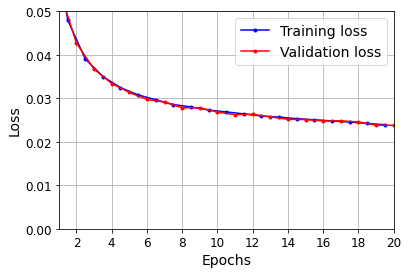

In [142]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [143]:
# Let's generate a new random series and test it
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

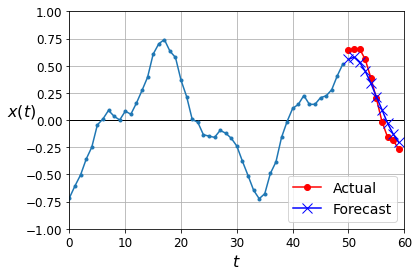

In [144]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


# GRUs

Gated Recurrent Unit (GRU) cell is a simplified version of LTSM cell, which tends to perform as well. 

![Neuron inner working](images/Figure_15_10.png)


* Both state vectors are merged into single vector $h_{(t)}$.
* A single gate controller $z_{(t)}$ controls both the forget gate and the input gate. If the gate controller outputs a 1, the forget gate is open (= 1) and the input gate is
closed (1 – 1 = 0). If it outputs a 0, the opposite happens. In other words, whenever a memory must be stored, the location where it will be stored is erased first. It is also a common design of LTSM.
* There is no output gate; the full state vector is output at every time step. However, there is a new gate controller r(t) that controls which part of the previous state will be shown to the main layer $g_{(t)}$.

The equations for GRU are:

$$\begin{aligned}
z_{(t)} &= \sigma (W_{xz}^T \cdot x_{(t)} + W_{hz}^T \cdot h_{(t-1)} + b_z)\\
r_{(t)} &= \sigma (W_{xr}^T \cdot x_{(t)} + W_{hr}^T \cdot h_{(t-1)} + b_f)\\
g_{(t)} &= \tanh(W_{xg}^T \cdot x_{(t)} + W_{hg}^T (r_{(t)} \otimes  h_{(t-1)} )+ b_g)\\
h_{(t)} &= z_{(t)} \otimes h_{(t-1)} + (1 - z_{(t)}) \otimes  g_{(t)}\\
\end{aligned}$$


In [145]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
# MSU of the last step output
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==

In [146]:
model.evaluate(X_valid, Y_valid)
# In our case performance is identical to LTSM

63/63 [==============================] - 0s 5ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.010262809693813324]

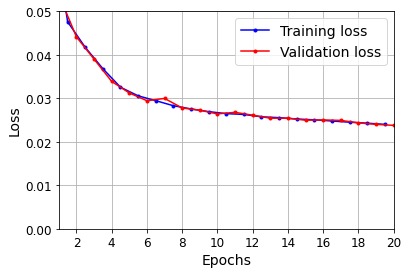

In [147]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [148]:
np.random.seed(43)
# Plot prediction
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

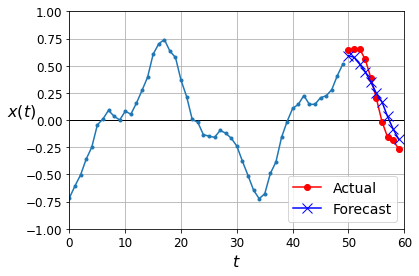

In [149]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


LSTM and GRU cells are one of the main reasons behind the success of RNNs. Yet
while they can tackle much longer sequences than simple RNNs, they still have a
fairly limited short-term memory, and they have a hard time learning long-term patterns
in sequences of 100 time steps or more, such as audio samples, long time series,
or long sentences. One way to solve this is to shorten the input sequences, for example
using 1D convolutional layers.

## Using One-Dimensional Convolutional Layers to Process Sequences


In Chapter 14, talks a lot about 2D convolutional layers by skiding kernels (filters) across the image. 

. Here we will apply a 1D, basuically we will add to the model information about neighboring steps. 
* A 1D convolutional layer slides several kernels across a
sequence, producing a 1D feature map per kernel.
* Each kernel will learn to detect a
single very short sequential pattern (no longer than the kernel size). Kernel = 10 will produce 10 steps processed in the same time. 


stride - number of steps we shift our filters each time. We use filters = 4, strides = 2. So the first four steps will cover: [1,2,3,4] -> [3,4,5,6]. This effectively downsamples the targets. 




```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [150]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    # We sample steps starting form step 3 taking every other step, so instead of 24 steps we use 
                    #24 targets,
                    # through the whole x is used
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [==

In [151]:
Y_train[:,3::2].shape

(7000, 24, 10)

In [152]:
Y_train.shape

(7000, 50, 10)

## WaveNet


![WaveNet](images/WaveNet.png)


Is the model of stacked 1D convolutional layers, doubling the
dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on. This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns. 

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [153]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
# First is the input layers
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
# next is the convolutional layer, the padding="casual" ensures that there is no peeking into the future
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
# Final layers is convolutional with 10 filters predicting 10 steps 
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0669 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0324 - last_time_step_mse: 0.0193 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0244 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0240 - last_time_step_mse: 0.0117 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

Now let's try to predict stock market :)

In [213]:
!pip install pandas_datareader
!pip install yfinance --upgrade --no-cache-dir

#code reference:
# https://github.com/robertmartin8/MachineLearningStocks/blob/master/download_historical_prices.py
import os
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf

yf.pdr_override()

START_DATE = "2003-08-01"
END_DATE = "2015-01-01"

# Function to load stock market data
def build_stock_dataset(ticker_list, start=START_DATE, end=END_DATE):
    """
    Creates the dataset containing all stock prices
    :returns: stock_prices.csv
    """

    # Get all Adjusted Close prices for all the tickers in our list,
    # between START_DATE and END_DATE
    all_data = pdr.get_data_yahoo(ticker_list, start, end)
    stock_data = all_data["Adj Close"]

    # Remove any columns that hold no data, and print their tickers.
    stock_data.dropna(how="all", axis=1, inplace=True)
    missing_tickers = [
        ticker for ticker in ticker_list if ticker.upper() not in stock_data.columns
    ]
    print(f"{len(missing_tickers)} tickers are missing: \n {missing_tickers} ")
    # If there are only some missing datapoints, forward fill.
    stock_data.ffill(inplace=True)
    return stock_data



Requirement already up-to-date: yfinance in /Users/ir177/opt/anaconda3/lib/python3.8/site-packages (0.1.54)


In [227]:
START_DATE = "2018-01-01"
END_DATE = "2020-01-01"
ticker_list = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'INTC', 'HPQ', 'CRM']
df = build_stock_dataset(ticker_list, start=START_DATE, end=END_DATE)

[*********************100%***********************]  7 of 7 completed
0 tickers are missing: 
 [] 


<ipython-input-213-f8fbff334d7e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.dropna(how="all", axis=1, inplace=True)


In [237]:
# prepare forecasting data
from datetime import timedelta
from datetime import date
from datetime import datetime

#x = datetime.strptime('2019-07-01', "%Y-%m-%d")  + timedelta(days = 2)

y_valid = df.loc['2019-07-01':,'INTC'].to_numpy()
y_train = df.loc[:'2019-07-01','INTC'].to_numpy()
X_valid = df.loc['2019-07-01':,].to_numpy()
X_train = df.loc[:'2019-07-01':,].to_numpy()


In [238]:
# Randomly select 10 days


def get_batches(n_batches, X, y, window, duration):
    # get one batch
  def get_batch(X, y, window, duration):
    # window is the number of past days you observe and duration how long you hold the stock
    timedif = window + duration 
    # pick a random past date to start a batch
    rnd_ind =np.random.choice(np.arange(y[: -timedif].size))
    # The space of Y draw from 
    y_rest = y[rnd_ind : rnd_ind + timedif]
    # Y vector for each day in the window we observe Y's equal to stock holding duration
    y_dur = np.empty([window, duration])
    # Generate Y's for each of the window: If we hold stock for 10 days and observe 50 days of the past:
    # For each of the 50 days we have 10 future daily observations
    for t in range(0,window):
      y_dur[t] = y_rest[ t : t + duration]
    y_sample = y_dur
    X_sample = X[rnd_ind : rnd_ind + window]
    # Return samples
    return X_sample, y_sample 
# create shells for y and X for many bactches
  yb = np.empty([n_batches,  window, duration ])
  Xb = np.empty([n_batches, window, 7])
# add batches step by step
  for i in range(0, n_batches):
    X_i, y_i = get_batch(X, y, window, duration)
    yb[i]= y_i
    Xb[i] = X_i
  return Xb, yb

# get 5000 batches for training  
X_sample_tr, y_sample_tr = get_batches(5000, X_train, y_train, 30, 10) 
# get 5000 batches for validation
X_sample_val, y_sample_val  = get_batches(5000, X_valid, y_valid, 30, 10) 




In [242]:
# Import layer normilized LSTM
from tensorflow_addons.rnn.layer_norm_lstm_cell import LayerNormLSTMCell as LSTM_norm





# Keras model [250,150,50] RNN with Layer Norm LSTM cells
model = keras.models.Sequential([
    # Each input observation has 7 stocks
    keras.layers.RNN(LSTM_norm(250, input_shape=(None,7)), return_sequences= True),
    keras.layers.RNN(LSTM_norm(150), return_sequences= True),
    keras.layers.RNN(LSTM_norm(50), return_sequences= True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
# define MSE for the last step
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=10000,
    decay_rate=0.2)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss="mse", optimizer=opt, metrics=[last_time_step_mse])
history = model.fit(X_sample_tr, y_sample_tr, epochs=2,
                    validation_data=(X_sample_val, y_sample_val))


Epoch 1/2
157/157 [==============================] - 42s 265ms/step - loss: 115.8291 - last_time_step_mse: 116.5407 - val_loss: 29.5156 - val_last_time_step_mse: 42.9589
Epoch 2/2
157/157 [==============================] - 39s 251ms/step - loss: 12.0228 - last_time_step_mse: 11.5297 - val_loss: 30.2177 - val_last_time_step_mse: 43.9555


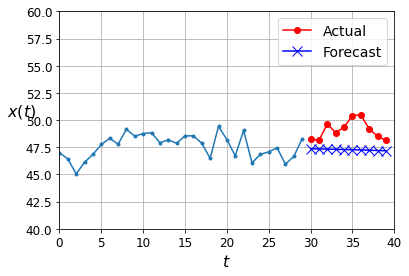

In [252]:
# Plot random date training forecast
n_steps = 30
ahead = 10
y_pred = model.predict(X_sample_tr)
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    n_steps = 30
    ahead = 10
    # 5 is the number of Intell
    plot_series(X[0, :, 5])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, 29, :], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, 29, :], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, 40, 60])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_sample_tr, y_sample_tr, y_pred)

In [251]:
X_sample_tr[0, :, 5]

array([47.00125122, 46.4173851 , 45.05188751, 46.12545013, 46.85057449,
       47.75462341, 48.32907867, 47.78287888, 49.14836884, 48.51742172,
       48.76226807, 48.83760834, 47.91471863, 48.18781662, 47.86763382,
       48.54567337, 48.55508804, 47.86763382, 46.48330688, 49.42147446,
       48.20664978, 46.70931625, 49.04478073, 46.06894302, 46.85057449,
       47.07659149, 47.44386292, 45.94652557, 46.66223526, 48.28198624])

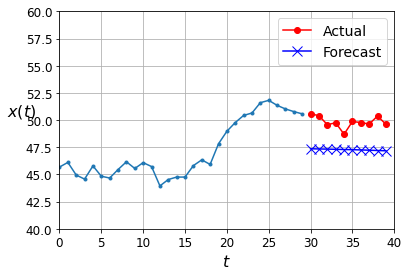

In [253]:
# Plot radnom date validation forecast
n_steps = 30
ahead = 10
y_pred = model.predict(X_sample_val)
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    # AMZN second column
    n_steps = 30
    ahead = 10
    plot_series(X[0, :, 5])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, 29, :], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, 29, :], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, 40, 60])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_sample_val, y_sample_val, y_pred)
